In [1]:
import schemdraw
import schemdraw.elements as elm
import numpy as np

In [37]:
class Circuito:
    def __init__(self):
        self.elements =0 # Variável que conta a quantidade de elementos
        self.elements_list =[] #List that saves the elements
        self.elements_list_interior=[]
        self.nodes = set()   #Set() faz com que os nós armazenados no conjunto sejam únicos
        self.malhas=[]
        self.node_map={}
        self.lista_nos=[]

    def element(self, Element: str, Start: tuple, End: tuple, Valor: float=0, Label: str = None):
        self.elements_list.append([Element, Start, End, Valor, Label])
        self.elements +=1
        #Adiciona nós aos conjuntos de nós
        #self.nodes.add(Start)
        #self.nodes.add(End)


    def element_interior(self, Element: str, Start: tuple, End: tuple, Valor: float=0, Label: str = None):
        self.elements_list_interior.append([Element, Start, End, Valor, Label])
        self.elements +=1
        #Adiciona nós aos conjuntos de nós
        self.nodes.add(Start)
        self.nodes.add(End)

    def premapnode (self):
      for iten in self.elements_list:
        Element, Start, End, Valor, Label = iten
        if (Element == 'Wire'):
          Wire_start = Start
          Wire_end = End
          for iten2 in self.elements_list:
            Element2,Start2 , End2, Valor2, Label2 = iten2
            if End2  == Wire_start:
              End2 = Wire_end
            elif Start2 == Wire_start:
              Start2 = Wire_end
            if Element2 != 'Wire':
              self.element_interior(Element2,Start2,End2,Valor2,Label2)
      


    def exibir_elementos(self):
        for i, elemento in enumerate(self.elements_list):
            print(f"Elemento {i+1}: {elemento}")


    def draw(self):
        with schemdraw.Drawing() as d:
            for iten in self.elements_list:
                if(iten[0]=='Resistor'):
                    d.add(elm.Resistor().endpoints(iten[1], iten[2]).label(str(iten[3])+" Ω",loc='top').label(iten[4],loc='bot'))
                elif(iten[0]=='Capacitor'):
                    valor_capacitor = f"{int(iten[3].imag)}j" if iten[3].imag % 1 == 0 else f"{iten[3].imag}j"
                    d.add(elm.Capacitor().endpoints(iten[1], iten[2]).label(valor_capacitor + " Ω", loc='top').label(iten[4], loc='bot'))
                elif(iten[0]=='Inductor'):
                    d.add(elm.Inductor().endpoints(iten[1], iten[2]).label(str(iten[3])+" Ω",loc='top').label(iten[4],loc='bot'))
                elif(iten[0] == 'Voltage Source'):
                    d.add(elm.SourceV().endpoints(iten[1], iten[2]).label(str(iten[3])+"V",loc='top').label(iten[4],loc='bot'))
                elif(iten[0] == 'Current Source'):
                    d.add(elm.SourceI().endpoints(iten[1], iten[2]).label(str(iten[3])+"A",loc='top').label(iten[4],loc='bot'))
                elif(iten[0] == 'Wire'):
                    d.add(elm.Line().endpoints(iten[1], iten[2]))

    def map_nodes(self):
        self.premapnode()
        #Criar um mapeamento para associar cada nó a um índice
        self.node_map = {}
        #Aqui vamos preencher o dicionário node_map
        # enumerate retorna
        for idx, node in enumerate(self.nodes):
            self.node_map[node] = idx #O nó é a chave do dicionário e o índice o valor
        print("Mapeamento de nós:", self.node_map)


    def montar_equacoes(self):
        n = len(self.nodes)
        G = np.zeros((n, n), dtype=complex) #Matriz condutância
        I = np.zeros(n, dtype=complex) #Matriz de correntes
        voltage_source_equations=[]

        for elm in self.elements_list_interior:
          #print(elm)
          Element, Start, End, Valor, Label = elm
          idx_start=self.node_map[Start]
          idx_end=self.node_map[End]

          if(Element=='Current Source'):
            I[idx_start] -= Valor
            I[idx_end] += Valor

          if(Element == 'Voltage Source' ):
            G = np.vstack([G, np.zeros(G.shape[1])])  # Adiciona uma nova linha
            G = np.hstack([G, np.zeros((G.shape[0], 1))])  # Adiciona uma nova coluna
            G[-1, idx_start] = -1
            G[-1, idx_end] = +1
            G[idx_start,-1] =-1
            G[idx_end,-1] =+1
            I = np.append(I, Valor)  # Adiciona o valor da fonte ao vetor de correntes

          elif(Element == 'Wire'):
            pass

          elif(Element == 'Resistor' or Element == 'Inductor' or Element == 'Capacitor' ):
            G[idx_start, idx_start] += 1 / Valor
            G[idx_end, idx_end] += 1 / Valor
            G[idx_start, idx_end] -= 1 / Valor
            G[idx_end, idx_start] -= 1 / Valor
            #print("Iteração: G ta:",G)

       
          

        return G, I

    def resolver_circuito(self):
        G, I = self.montar_equacoes()
        # Escolher um nó de referência, por exemplo, o primeiro nó mapeado
        ref_node = 2

        # Reduzir a matriz removendo a linha e a coluna do nó de referência
        G_reduced = np.delete(np.delete(G, ref_node, axis=0), ref_node, axis=1)
        I_reduced = np.delete(I, ref_node)

        try:
            # Resolver o sistema reduzido G * V = I
            V_reduced = np.linalg.solve(G_reduced, I_reduced)

            # Reconstruir o vetor completo de tensões
            V = np.insert(V_reduced, ref_node, 0)  # Define a tensão do nó de referência como 0
            print("Tensões nos nós:", V)
        except np.linalg.LinAlgError as e:
            print("Erro ao resolver o sistema:", e)
            V = None
        return V


    def mostrar_matriz_condutancia(self):
        G, I = self.montar_equacoes()
        linhas,colunas = G.shape
        for i in range (linhas):
          for j in range (colunas):
            print("{:.3f}".format(G[i,j]), "|",end=" ")
          print(" ")


In [32]:
x = np.zeros( (1,3 ))
print(x)

[[0. 0. 0.]]


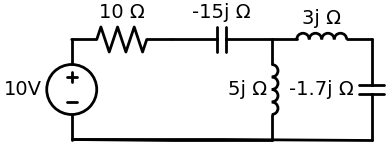

Mapeamento de nós: {(4, 0): 0, (0, 0): 1, (2, 0): 2, (6, -2): 3, (6, 0): 4, (4, -2): 5, (0, -2): 6}


In [9]:
circuito=Circuito()
circuito.element('Resistor',(0,0),(2,0),10,)
circuito.element('Capacitor',(2,0),(4,0),-15j)
circuito.element('Inductor',(4,0),(4,-2),5j,)
circuito.element('Wire',(4,-2),(0,-2))
circuito.element("Voltage Source",(0,-2),(0,0),10)
circuito.element("Inductor",(4,0),(6,0),3j)
circuito.element("Capacitor",(6,0),(6,-2),-1.7j)
circuito.element('Wire',(6,-2),(0,-2))

circuito.draw()
circuito.map_nodes()


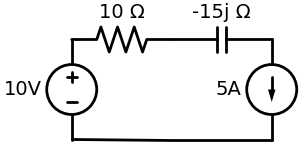

Mapeamento de nós: {(4, 0): 0, (2, 0): 1, (0, -2): 2, (0, 0): 3}


In [50]:
circuito=Circuito()
circuito.element('Resistor',(0,0),(2,0),10,)
circuito.element('Capacitor',(2,0),(4,0),-15j)
circuito.element('Current Source',(4,0),(4,-2),5,)
circuito.element('Wire',(4,-2),(0,-2))
#circuito.element('Wire',(4,-2),(2,-2))
#circuito.element('Wire',(2,-2),(0,-2))
circuito.element("Voltage Source",(0,-2),(0,0),10)
#circuito.element('Resistor',(2,0),(0,-2),2)


circuito.draw()
circuito.map_nodes()
G,I=circuito.montar_equacoes()
#circuito.mostrar_matriz_condutancia()

In [51]:
G,I = circuito.montar_equacoes()
print(I)

[-5.+0.j  0.+0.j  5.+0.j  0.+0.j 10.+0.j]


In [52]:
circuito.mostrar_matriz_condutancia()

0.000+0.067j | 0.000-0.067j | 0.000+0.000j | 0.000+0.000j | 0.000+0.000j |  
0.000-0.067j | 0.100+0.067j | 0.000+0.000j | -0.100+0.000j | 0.000+0.000j |  
0.000+0.000j | 0.000+0.000j | 0.000+0.000j | 0.000+0.000j | -1.000+0.000j |  
0.000+0.000j | -0.100+0.000j | 0.000+0.000j | 0.100+0.000j | 1.000+0.000j |  
0.000+0.000j | 0.000+0.000j | -1.000+0.000j | 1.000+0.000j | 0.000+0.000j |  


In [54]:
V=circuito.resolver_circuito()

Tensões nos nós: [-40.+75.j -40. +0.j   0. +0.j  10. +0.j  -5. +0.j]
